In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'legend.fontsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
df = pd.read_csv("../data/bokeh_df.csv")

In [5]:
toi_811 = pd.read_csv("data/TICv8_1_TIC_100757807.csv", skiprows=4)
toi_852 = pd.read_csv("data/TICv8_1_TIC_29918916.csv", skiprows=4)

In [18]:
[col for col in toi_811.columns if 'logg' in col]

['Teff', 'e_Teff', 'eneg_Teff', 'epos_Teff', 'TeffFlag']

In [19]:
def abs_mag(m, D):
    return m - 5*np.log10(D) + 5

toi_811_MG = abs_mag(toi_811.GAIAmag, 1./toi_811.plx*1e3)
toi_852_MG = abs_mag(toi_852.GAIAmag, 1./toi_852.plx*1e3)

toi_811_prot = 3.21
toi_852_prot = 5.8

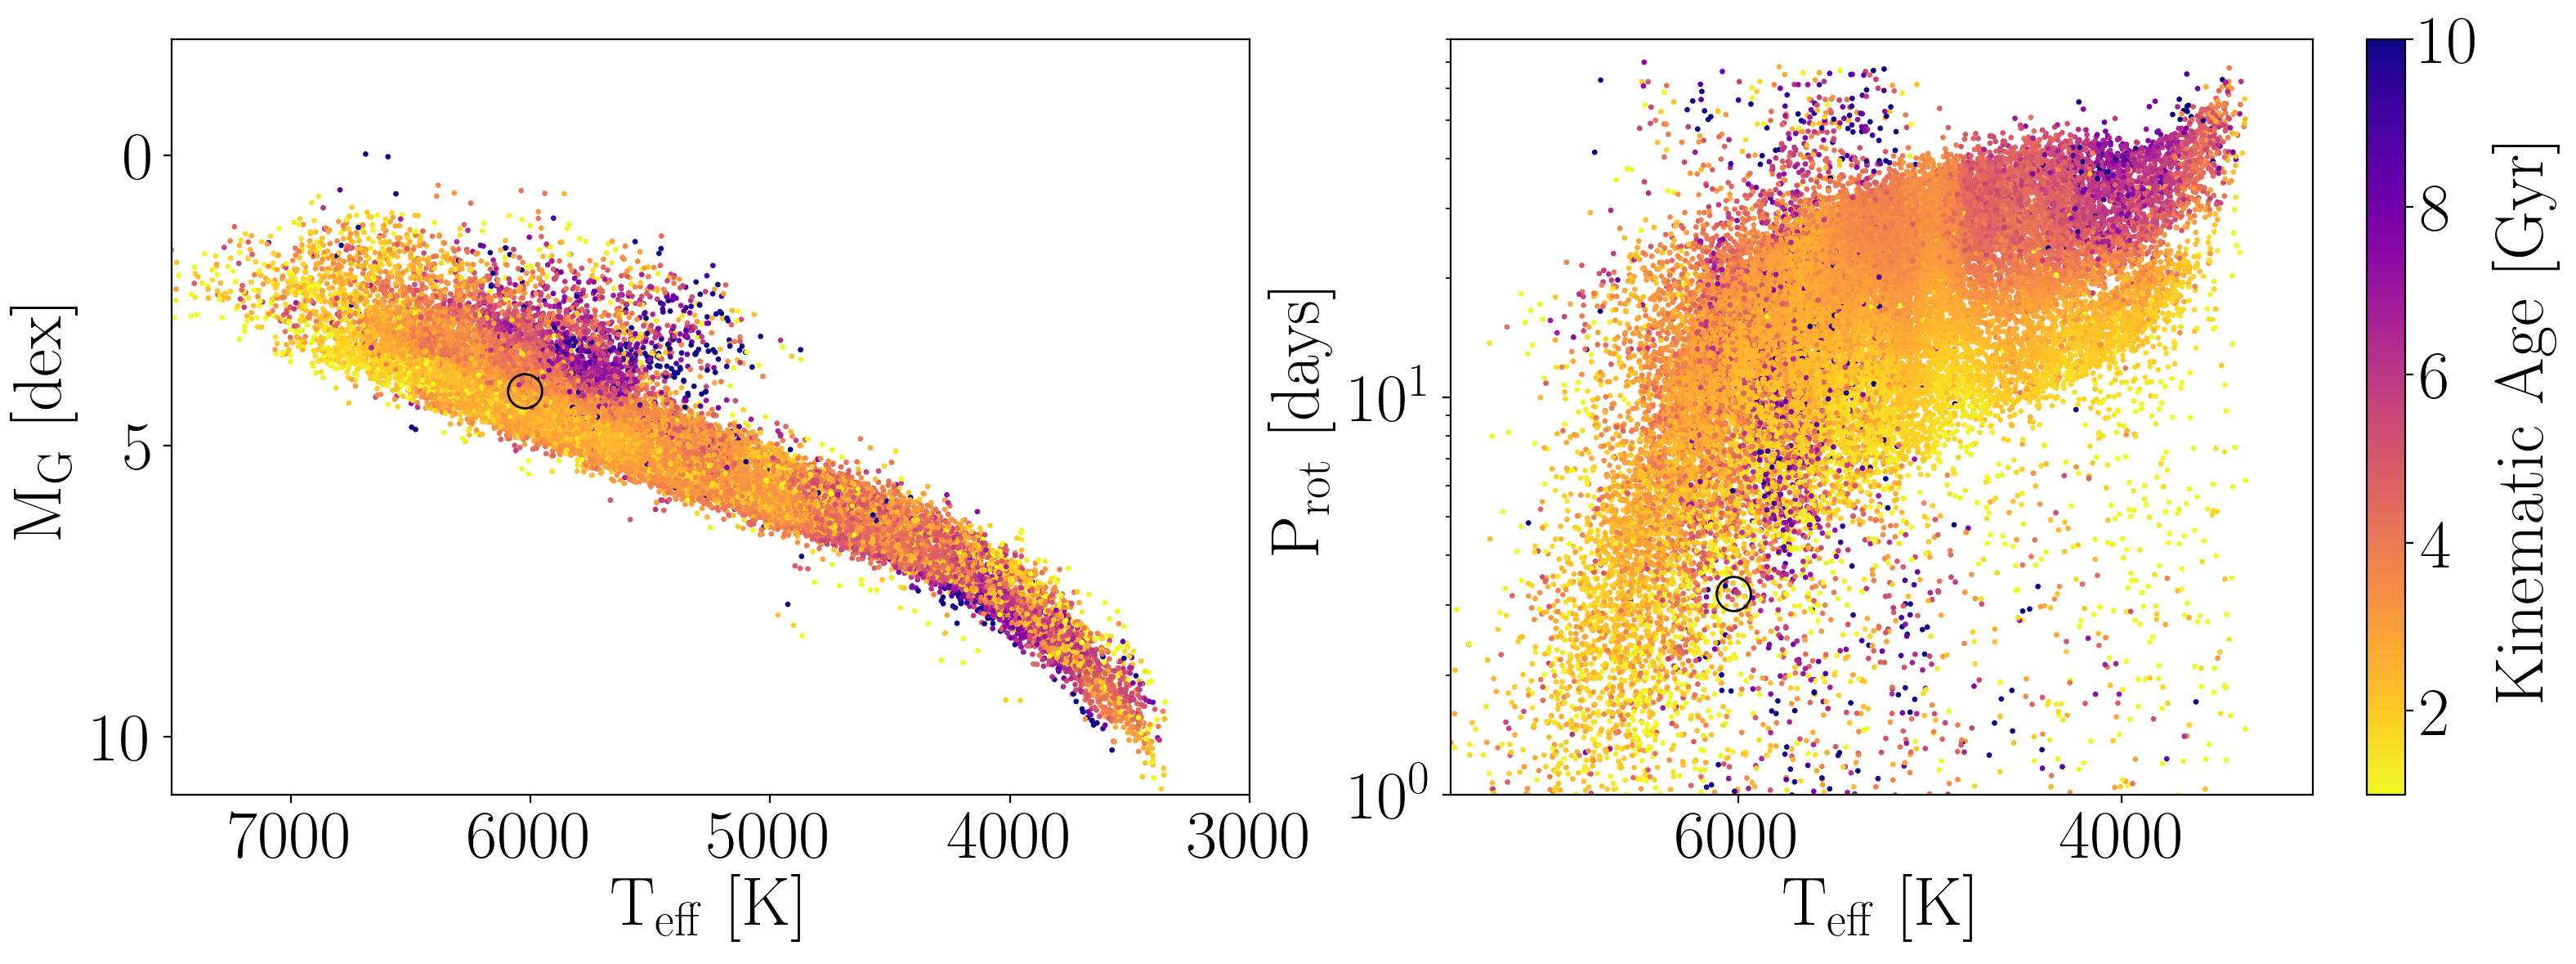

In [20]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(toi_811.Teff, toi_811_MG, "o", color="none", mec="k", ms=15, zorder=1)

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(toi_811.Teff, toi_811_prot, "o", color="none", mec="k", ms=15, zorder=1)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

In [22]:
[col for col in toi_811.columns if 'J' in col]

['Jmag', 'e_Jmag']

Calculate an age using praesepe model.

In [28]:
import stardate2 as sd2
import emcee

ndim, nwalkers = 1, 25
log_age_init = 8
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

bprp = float(toi_811.gaiabp.values) - float(toi_811.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[toi_811_prot, .3, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

0.23 + 0.03 - 0.03


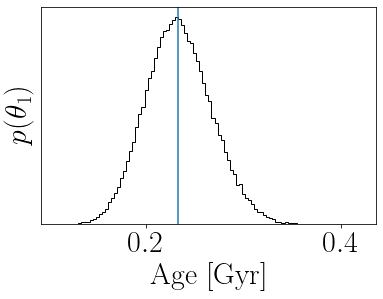

In [29]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Now calculate a full stardate age.

In [23]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"J": (float(toi_811.Jmag.values), float(toi_811.e_Jmag.values)),
              "H": (float(toi_811.Hmag.values), float(toi_811.e_Hmag.values)),
              "K": (float(toi_811.Kmag.values), float(toi_811.e_Kmag.values)),
              "G": (float(toi_811.GAIAmag.values), float(toi_811.e_GAIAmag.values)),
              "BP": (float(toi_811.gaiabp.values), float(toi_811.e_gaiabp.values)),
              "RP": (float(toi_811.gaiarp.values), float(toi_811.e_gaiarp.values)),
              "parallax": (float(toi_811.plx.values), float(toi_811.e_plx.values))}
iso_params

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


{'J': (10.397, 0.040999999999999995),
 'H': (10.147, 0.047),
 'K': (10.076, 0.040999999999999995),
 'G': (11.3385, 0.000515),
 'BP': (11.6557, 0.001046),
 'RP': (10.8867, 0.0009130000000000001),
 'parallax': (3.4922800000000005, 0.021055900000000002)}

In [36]:
# Set up the star object.
star = sd.Star(iso_params, prot=toi_811_prot, prot_err=.3, Av=.01, Av_err=.2)

# Run the MCMC
star.fit(inits=[300, 8, 0, float(1./(toi_811.plx.values*1e-3)), 0], max_n=10000, burnin=100)

100%|██████████| 10000/10000 [02:38<00:00, 63.04it/s]


nsteps 10000 burnin 100


In [37]:
# # Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results(burnin=100)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

stellar age = 0.55 + 0.05 + 0.02


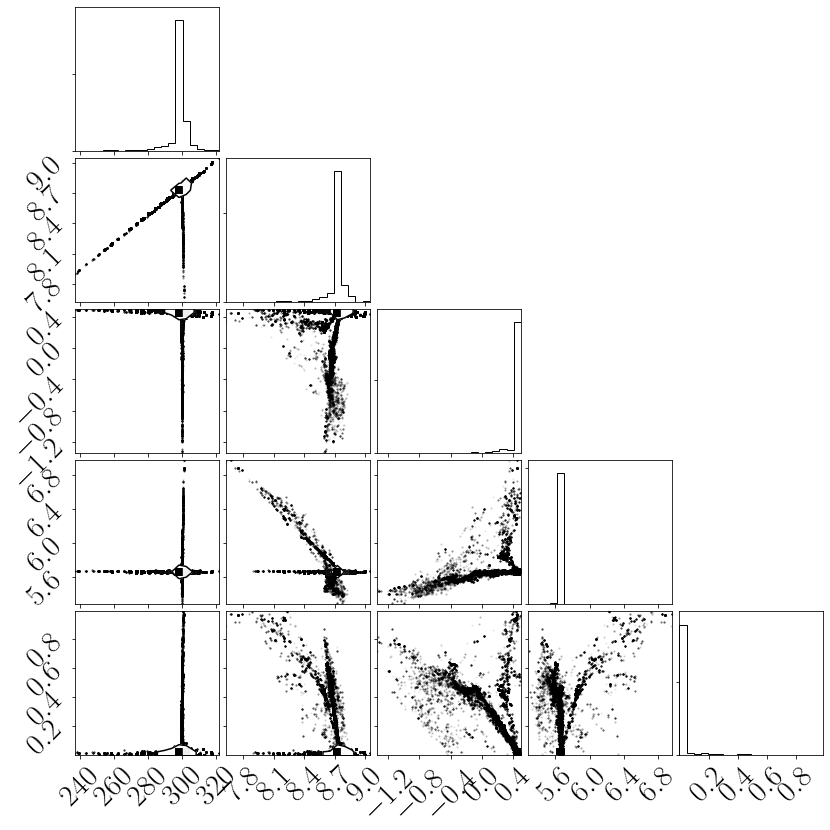

In [38]:
import corner
corner.corner(star.samples);

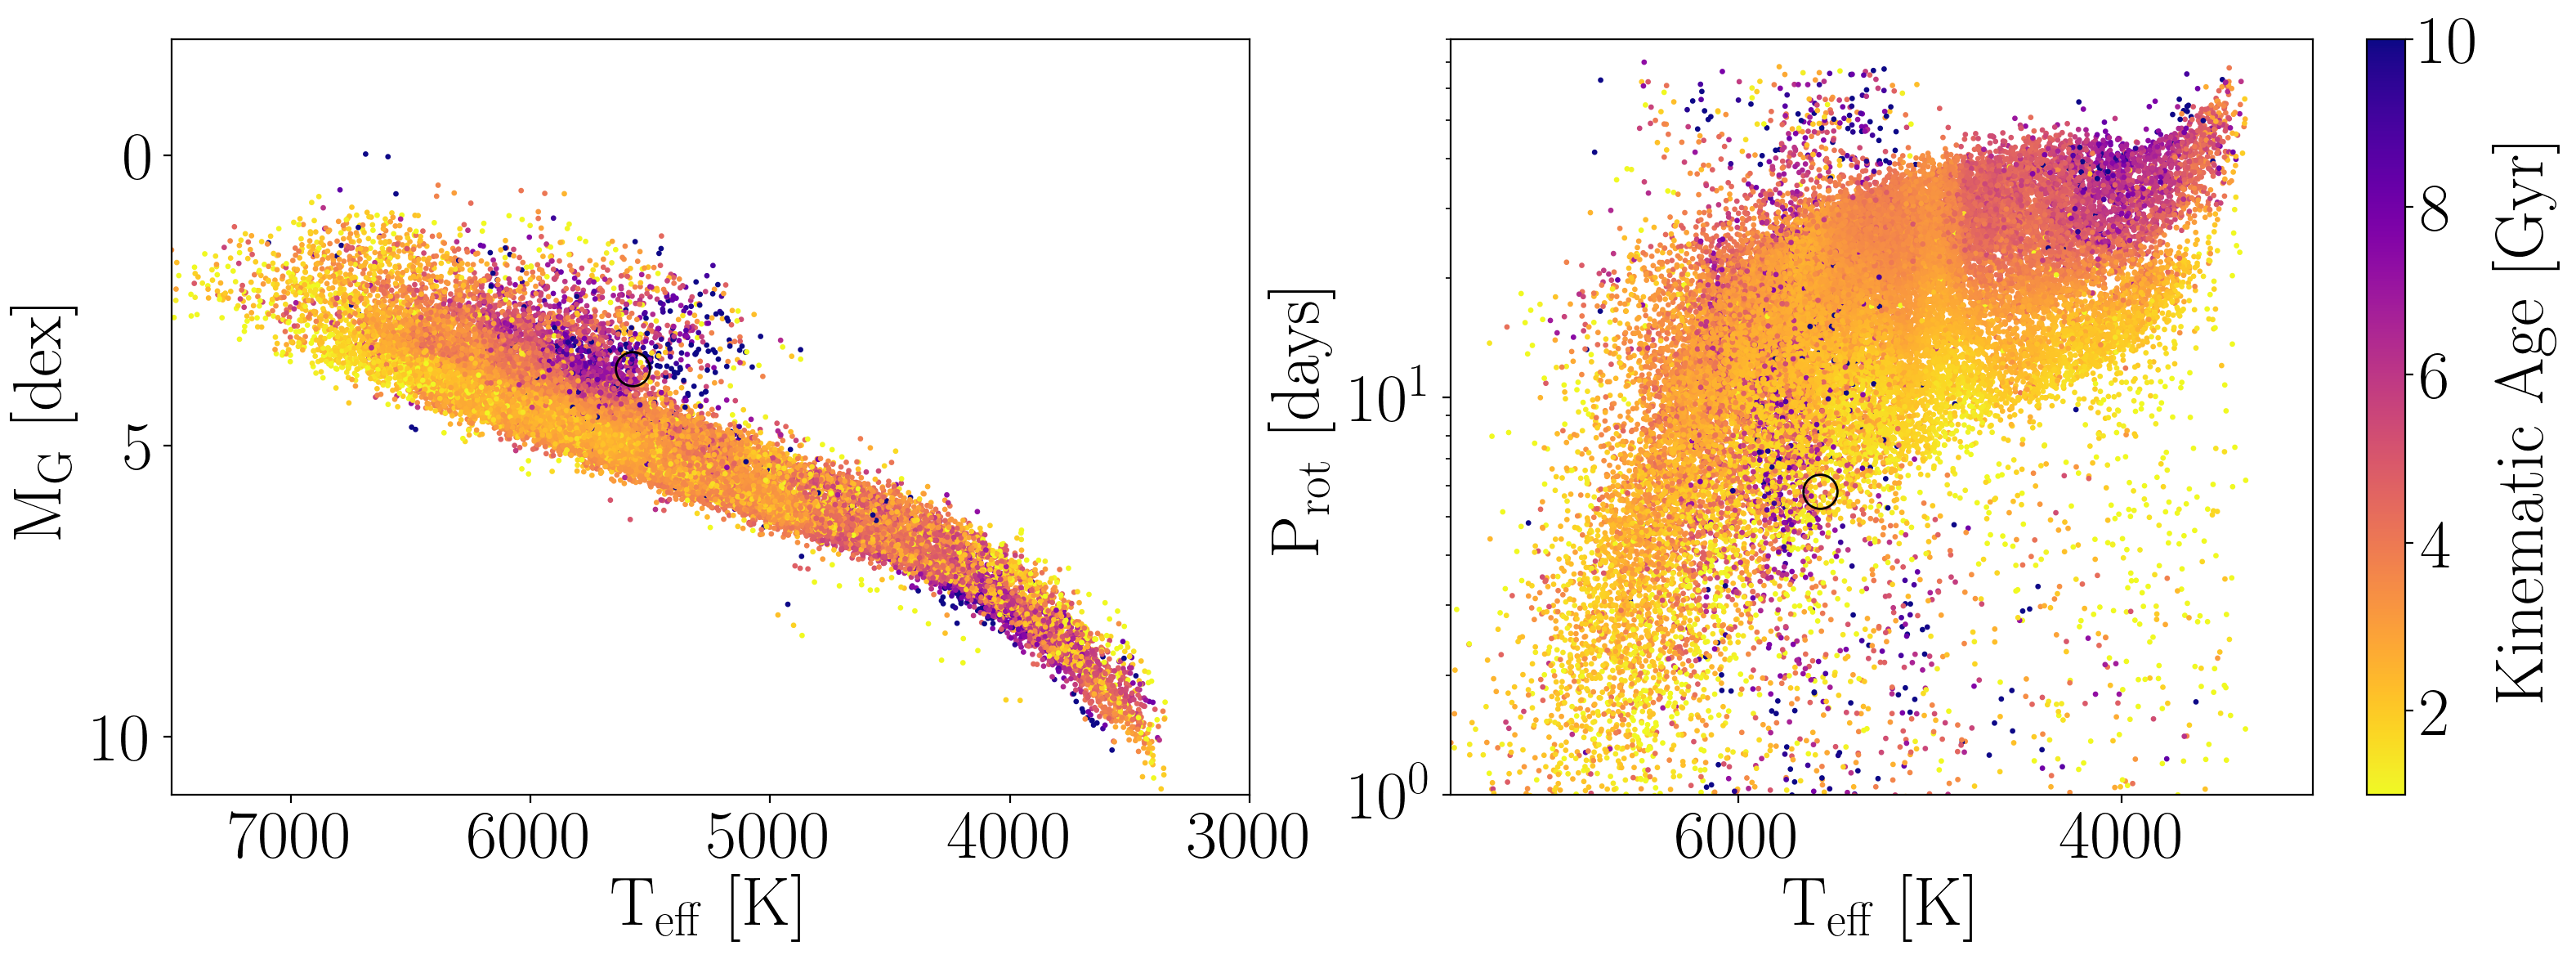

In [39]:
fig = plt.figure(figsize=(16, 6), dpi=200)
ax1 = fig.add_subplot(121)
ax1.scatter(df.teff, df.M_G, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax1.set_xlim(7500, 3000)
ax1.set_ylim(11, -2)
ax1.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax1.set_ylabel("$\mathrm{M_G~[dex]}$")
ax1.plot(toi_852.Teff, toi_852_MG, "o", color="none", mec="k", ms=15, zorder=1)

ax2 = fig.add_subplot(122)
cb = ax2.scatter(df.teff, df.prot, c=df.kin_age, vmin=1, vmax=10, cmap="plasma_r", s=2, zorder=0)#, alpha=.5)
ax2.set_xlim(7500, 3000)
ax2.set_ylim(1, 80)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{P_{rot}~[days]}$")
ax2.set_yscale("log")
ax2.plot(toi_852.Teff, toi_852_prot, "o", color="none", mec="k", ms=15, zorder=1)

plt.colorbar(cb, label="$\mathrm{Kinematic~Age~[Gyr]}$")
plt.tight_layout()

Calculate an age using praesepe model.

In [41]:
ndim, nwalkers = 1, 25
log_age_init = 10
p0 = np.random.randn(nwalkers, ndim)*1e-2 + log_age_init

bprp = float(toi_852.gaiabp.values) - float(toi_852.gaiarp.values)

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[toi_852_prot, 1, bprp, sd2.angus_2019_model])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

0.32 + 0.10 - 0.09


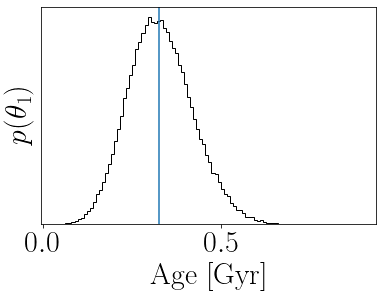

In [42]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Now calculate a full stardate age.

In [44]:
import stardate as sd

# Create a dictionary of observables
iso_params = {"J": (float(toi_852.Jmag.values), float(toi_852.e_Jmag.values)),
              "H": (float(toi_852.Hmag.values), float(toi_852.e_Hmag.values)),
              "K": (float(toi_852.Kmag.values), float(toi_852.e_Kmag.values)),
              "G": (float(toi_852.GAIAmag.values), float(toi_852.e_GAIAmag.values)),
              "BP": (float(toi_852.gaiabp.values), float(toi_852.e_gaiabp.values)),
              "RP": (float(toi_852.gaiarp.values), float(toi_852.e_gaiarp.values)),
              "parallax": (float(toi_852.plx.values), float(toi_852.e_plx.values))}
iso_params

{'J': (10.277999999999999, 0.022000000000000002),
 'H': (9.966000000000001, 0.022000000000000002),
 'K': (9.88, 0.02),
 'G': (11.4227, 0.001667),
 'BP': (11.812000000000001, 0.003899),
 'RP': (10.9055, 0.0032700000000000003),
 'parallax': (2.81716, 0.042068400000000006)}

In [45]:
# Set up the star object.
star = sd.Star(iso_params, prot=toi_852_prot, prot_err=1, Av=.01, Av_err=.2)

# Run the MCMC
star.fit(inits=[350, log_age_init, 0, float(1./(toi_852.plx.values*1e-3)), 0], max_n=10000, burnin=100)

100%|██████████| 10000/10000 [02:50<00:00, 58.51it/s]

nsteps 10000 burnin 100


In [47]:
# # Print the median age with the 16th and 84th percentile uncertainties.
age, errp, errm, samples = star.age_results(burnin=100)
print("stellar age = {0:.2f} + {1:.2f} + {2:.2f}".format(age, errp, errm))

stellar age = 2.16 + 0.32 + 0.71


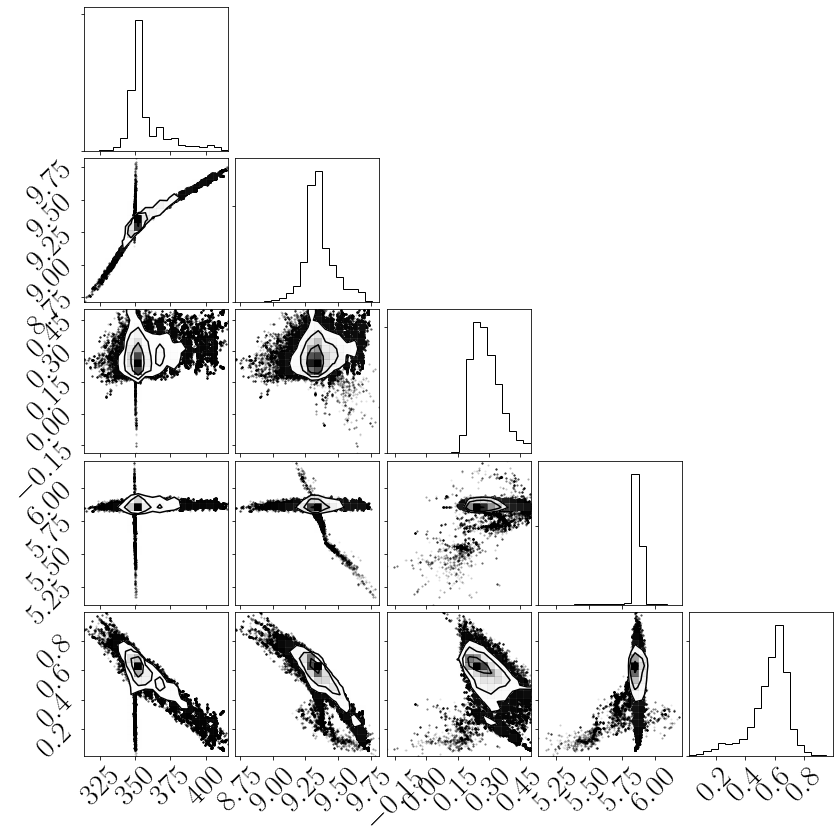

In [46]:
import corner
corner.corner(star.samples);

In [48]:
gp = sd2.GP_model()
print(gp.pred_at(8, toi_811.Teff))

[4.18015214]


In [ ]:
ndim, nwalkers = 1, 25

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd2.lnprob, args=[toi_811_prot, .3, toi_811.Teff.values, gp.pred_at])
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 8
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 5000);

In [ ]:
samples = sampler.get_chain(flat=True)
lin_samps = (10**samples)*1e-9
lin_samps = lin_samps[lin_samps > 1]
median_age = np.median(lin_samps)
errm = median_age - np.percentile(lin_samps, 16)
errp = np.percentile(lin_samps, 84) - median_age
print(f"{median_age:.2f} + {errp:.2f} - {errm:.2f}")

plt.hist(lin_samps, 100, color="k", histtype="step")
plt.axvline(median_age)
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [ ]:
print(toi_811.logg)